## Packages and formatting

In [ ]:
library(tidyverse)
library(fpp3)
library(lubridate)
options(readr.show_col_types = FALSE)
options(repr.plot.width = 12, repr.plot.height = 6)
# options(repr.plot.width = NULL, repr.plot.height = NULL)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ──────────────────────────────────────────── fpp3 1.0.2 ──

✔ tsibble     1.1.6     ✔ feasts      0.4.2
✔ tsibbledata 0.4.1     ✔ fable       0.4.1

── Conflicts ───────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks ba

## Load data

In [ ]:
# Load the CSVs
calendar_raw <- read_csv("calendar_afcs2025.csv", show_col_types = FALSE)
prices_raw   <- read_csv("sell_prices_afcs2025.csv", show_col_types = FALSE)
train_raw    <- read_csv("sales_train_validation_afcs2025.csv", show_col_types = FALSE)
val_raw      <- read_csv("sales_test_validation_afcs2025.csv", show_col_types = FALSE)


## Clean data

In [ ]:
# Clean Calendar
calendar <- calendar_raw |>
  mutate(date = mdy(date)) |>
  arrange(date) |>
  mutate(d = paste0("d_", row_number())) |>
  select(d, date, wm_yr_wk, snap_TX, event_name_1, event_name_2)


# Function for to combine sales series with calendar and price series

process_data <- function(raw_df, calendar_df, prices_df) {

  df_long <- raw_df |>
    mutate(item_id = sub("_TX_3_.*", "", id), 
           store_id = "TX_3") |>
    select(-id) |>
    pivot_longer(
      cols = starts_with("d_"), 
      names_to = "d", 
      values_to = "sales"
    )
  
  df_joined <- df_long |>
    left_join(calendar_df, by = "d") |>
    left_join(prices_df, by = c("store_id", "item_id", "wm_yr_wk"))
  
  df_ts <- df_joined |>
    as_tsibble(key = item_id, index = date) |>
    mutate(
      is_event = if_else(!is.na(event_name_1), 1, 0),
    )
  
  return(df_ts)
}

train_ts <- process_data(train_raw, calendar, prices_raw)
val_ts <- process_data(val_raw, calendar, prices_raw)


# EDA

In [ ]:
ts_data <- train_ts

# Aggregate sales for all products in store TX3 per day.
total_sales_tx3 <- ts_data |>
  index_by(date) |>
  summarise(total_sales = sum(sales, na.rm = TRUE)) |>
  fill_gaps(total_sales = 0) 


# 4. EXPLORATORY DATA ANALYSIS (EDA)

# A. General Trend (Moving Averages)
total_sales_tx3 |>
  mutate(
    MA_7 = slider::slide_dbl(total_sales, mean, .before = 6, .complete = TRUE),
    MA_28 = slider::slide_dbl(total_sales, mean, .before = 27, .complete = TRUE)
  ) |>
  autoplot(total_sales, color="gray80") + # Raw data in light gray
  geom_line(aes(y = MA_7), color = "steelblue", linewidth = 0.8) +
  geom_line(aes(y = MA_28), color = "darkred", linewidth = 1) +
  labs(title = "Daily Sales with Moving Averages",
       subtitle = "Blue = 7-day average, Red = 28-day (long term trend)",
       y = "Total Sales", x = "Date") +
  theme_minimal()

# B. Seasonality (Boxplots)
# Day of the week pattern
total_sales_tx3 |>
  mutate(day_name = wday(date, label = TRUE, week_start = 1)) |> 
  ggplot(aes(x = day_name, y = total_sales)) +
  geom_boxplot(fill = "steelblue", alpha = 0.7) +
  labs(title = "Seasonal Pattern: Sales Distribution per Weekday",
       x = "Day", y = "Total Sales") +
  theme_minimal()

# Month of the year pattern
total_sales_tx3 |>
  mutate(month_name = month(date, label = TRUE)) |>
  ggplot(aes(x = month_name, y = total_sales)) +
  geom_boxplot(fill = "orange", alpha = 0.7) +
  labs(title = "Seasonal Pattern: Sales Distribution per Month",
       x = "Month", y = "Total Sales") +
  theme_minimal()

# Shows how the weekly pattern behaves over the years
total_sales_tx3 |>
  gg_season(total_sales, period = "week") +
  labs(title = "Seasonal Plot: Weekly pattern over time",
       y = "Sales") +
  theme_minimal()

# Shows how sales evolve per month over the years (Subseries)
total_sales_tx3 |>
  gg_subseries(total_sales, period = "month") +
  labs(title = "Subseries Plot: Monthly evolution",
       y = "Sales") +
  theme_minimal()


# D. Autocorrelation (ACF)
total_sales_tx3 |>
  ACF(total_sales, lag_max = 35) |>
  autoplot() +
  labs(title = "Autocorrelation Plot (ACF)",
       subtitle = "Peaks at 7, 14, 21 indicate a very strong weekly pattern") +
  theme_minimal()


# 5. SUMMARY STATISTICS
summary_stats <- total_sales_tx3 |>
  as_tibble() |>
  summarise(
    Mean_Sales = mean(total_sales),
    Median_Sales = median(total_sales),
    Min_Sales = min(total_sales),
    Max_Sales = max(total_sales),
    SD_Sales = sd(total_sales),
    Total_Days = n()
  )

print(summary_stats)

# Modelling

In [5]:
print("Fitting Models...")

fit <- train_ts |>
  model(
    SNaive = SNAIVE(sales ~ lag(7)),
    TSLM_Optimized = TSLM(log(sales + 1) ~ season() + snap_TX + sell_price + is_event)
  )

print("Forecasting...")
fc <- fit |>
  forecast(new_data = val_ts)

print("Calculating RMSE...")
accuracy_table <- fc |>
  accuracy(val_ts) |>
  group_by(.model) |>
  summarise(RMSE = mean(RMSE, na.rm = TRUE)) |>
  arrange(RMSE)

print(accuracy_table)

[1] "Fitting Models..."
[1] "Forecasting..."


Warning message:
“There were 179 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TSLM_Optimized = (function (object, ...) ...`.
Caused by warning:
! prediction from a rank-deficient fit may be misleading
ℹ Run `dplyr::last_dplyr_warnings()` to see the 178 remaining warnings.”


[1] "Calculating RMSE..."
# A tibble: 2 × 2
  .model          RMSE
  <chr>          <dbl>
1 TSLM_Optimized  2.00
2 SNaive          2.32


.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
TSLM_Optimized,1522.677,0


Warning message:
“`gg_tsresiduals()` was deprecated in feasts 0.4.2.
ℹ Please use `ggtime::gg_tsresiduals()` instead.”
Warning message:
“Removed 196 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 196 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 196 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 196 rows containing missing values or values outside the scale range
(`geom_rug()`).”


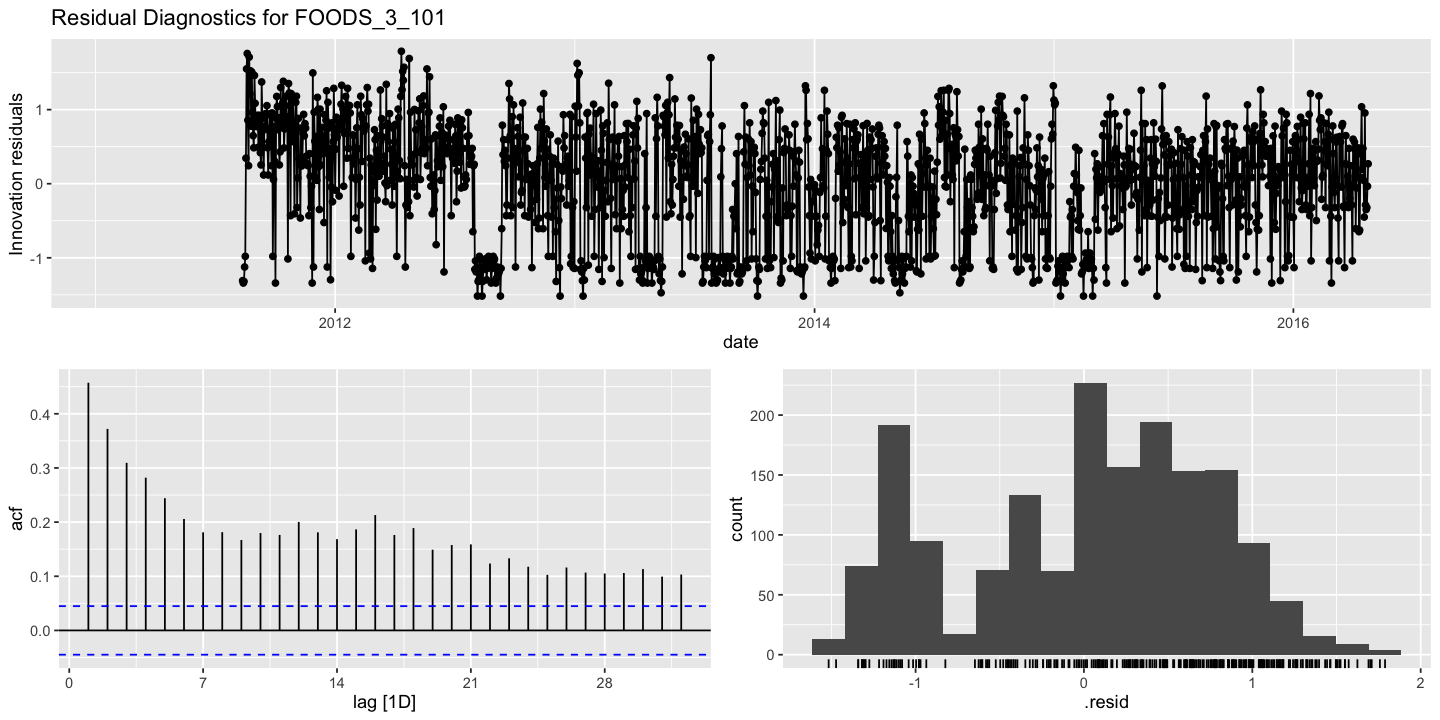

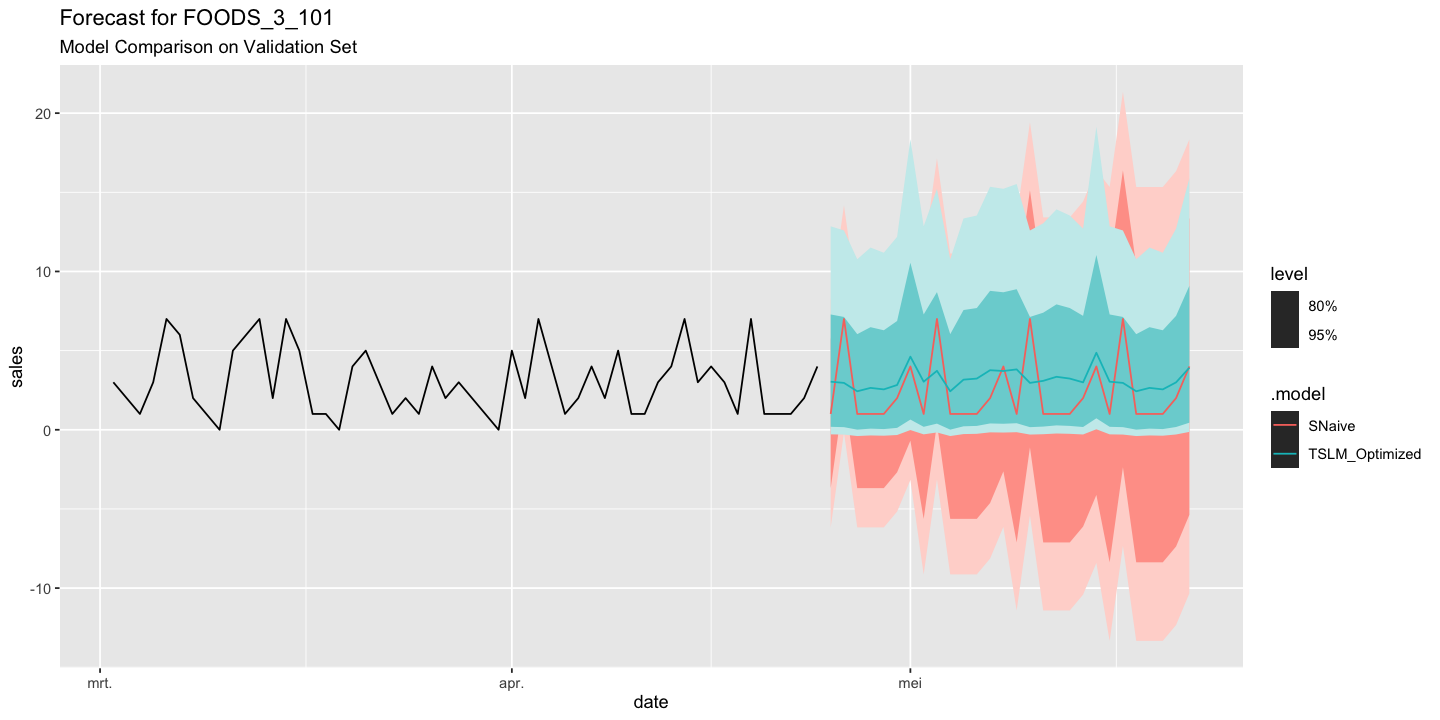

In [6]:
## Diagnostics

example_item <- unique(train_ts$item_id)[100]

aug <- fit |>
  filter(item_id == example_item) |>
  select(TSLM_Optimized) |>
  augment()

features(aug, .innov, ljung_box, lag = 14)

fit |>
  filter(item_id == example_item) |>
  select(TSLM_Optimized) |>
  gg_tsresiduals() +
  labs(title = paste("Residual Diagnostics for", example_item))

fc |>
  filter(item_id == example_item) |>
  autoplot(filter(train_ts, item_id == example_item, date > ymd("2016-03-01"))) +
  labs(title = paste("Forecast for", example_item),
       subtitle = "Model Comparison on Validation Set")

In [7]:
# --- FINAL EVALUATION STEP ---
print("Loading Evaluation Data (Ground Truth)...")

# 1. Load the Evaluation File (d_1942 - d_1969)
eval_raw <- read_csv("sales_test_evaluation_afcs_2025.csv", show_col_types = FALSE)

# 2. Process it using your function
eval_ts <- process_data(eval_raw, calendar, prices_raw)

# 3. Forecast using the winning model (TSLM)
print("Forecasting Evaluation Period...")
fc_eval <- fit |>
  # We use the TSLM_Optimized model because it won
  select(TSLM_Optimized) |>
  forecast(new_data = eval_ts)

# 4. Calculate Final RMSE
print("Calculating Final Report RMSE...")
final_accuracy <- fc_eval |>
  accuracy(eval_ts) |>
  summarise(RMSE = mean(RMSE, na.rm = TRUE))

print("--- FINAL SCORE FOR ABSTRACT ---")
print(final_accuracy)

[1] "Loading Evaluation Data (Ground Truth)..."
[1] "Forecasting Evaluation Period..."


Warning message:
“There were 179 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TSLM_Optimized = (function (object, ...) ...`.
Caused by warning:
! prediction from a rank-deficient fit may be misleading
ℹ Run `dplyr::last_dplyr_warnings()` to see the 178 remaining warnings.”


[1] "Calculating Final Report RMSE..."
[1] "--- FINAL SCORE FOR ABSTRACT ---"
# A tibble: 1 × 1
   RMSE
  <dbl>
1  2.16


In [8]:
print("Running Ljung-Box Test on all 823 items...")

# 1. Calculate residuals for ALL items
# (This might take ~10-20 seconds because it processes 1.5 million rows)
aug_all <- fit |>
  select(TSLM_Optimized) |>
  augment()

# 2. Compute the test statistic for each item
# This creates a table with 823 rows
lb_results <- aug_all |>
  features(.innov, ljung_box, lag = 14)

# 3. Calculate the Global Average
lb_summary <- lb_results |>
  summarise(
    Average_Stat = mean(lb_stat, na.rm = TRUE),
    Average_P_Value = mean(lb_pvalue, na.rm = TRUE),
    # Count how many items actually "Passed" the test (p > 0.05)
    Items_Passing = sum(lb_pvalue > 0.05, na.rm = TRUE)
  )

print("--- GLOBAL RESIDUAL DIAGNOSTICS ---")
print(lb_summary)

[1] "Running Ljung-Box Test on all 823 items..."
[1] "--- GLOBAL RESIDUAL DIAGNOSTICS ---"
# A tibble: 1 × 3
  Average_Stat Average_P_Value Items_Passing
         <dbl>           <dbl>         <int>
1        1710.          0.0347            64
